First Task Soccer Pitch Marking

In [2]:
import os 
import numpy as np
import pandas as pd
import cv2 as cv
import json
import random

calibration_folder = "SoccerNet/calibration/test"
clips_folder = "../clips/08fd33_4.mp4"
segmentation_folder = "SoccerNet/calibration/segmentation"

In [3]:
frame_list = os.listdir("SoccerNet/calibration/test/")
frame_list = [f for f in frame_list if ".jpg" in f]
frame = frame_list[random.randint(0, len(frame_list))]
frame_index = frame.split(".")[0]
frame_index

'02682'

In [4]:
from src.soccerpitch import SoccerPitch

lines_palette = [0, 0, 0]
for line_class in SoccerPitch.lines_classes:
    lines_palette.extend(SoccerPitch.palette[line_class])

(540, 960, 3)


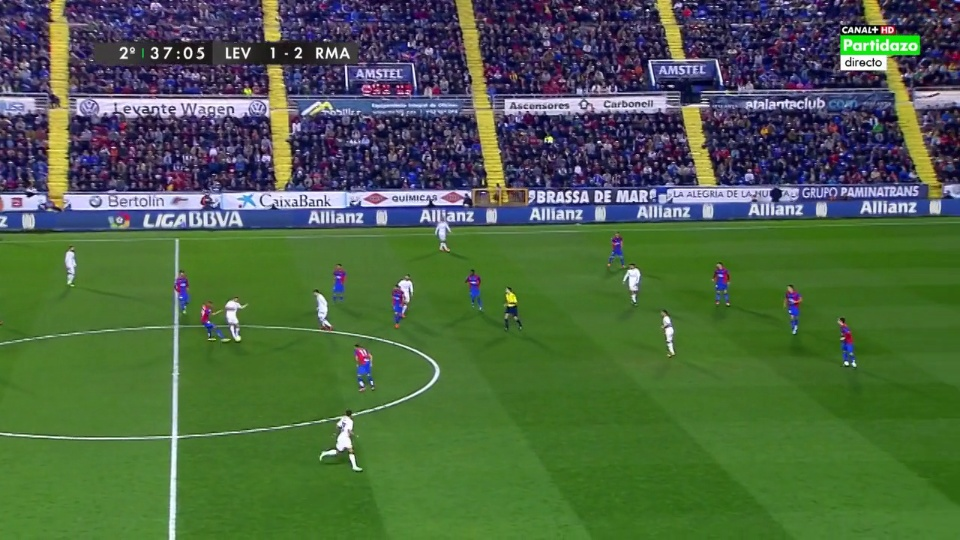

In [5]:
from PIL import Image

#test image
data_dir = "SoccerNet/calibration/test"
image = cv.imread(os.path.join(data_dir, frame))
image = cv.resize(image, (960, 540))
print(image.shape)

rgbimage = cv.cvtColor(image, cv.COLOR_BGR2RGB)
pil_image = Image.fromarray(rgbimage)
pil_image

In [6]:
# Baseline 1 : extracting extremities of soccer pitch elements
from src.detect_extremities import SegmentationNetwork

seg_net = SegmentationNetwork(
    "resources/soccer_pitch_segmentation.pth",
    "resources/mean.npy",
    "resources/std.npy"
)

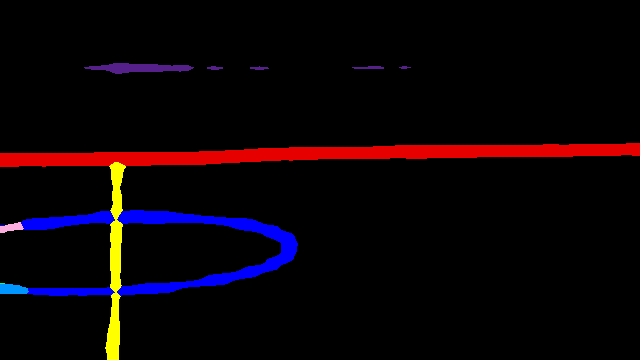

In [7]:
seg_mask = seg_net.analyse_image(image)
mask = Image.fromarray(seg_mask.astype(np.uint8))
mask = mask.convert('P')
mask.putpalette(lines_palette)
mask

In [ ]:
# Membuat folder jika belum ada
os.makedirs(segmentation_folder, exist_ok=True)

# Load model segmentasi
seg_net = SegmentationNetwork(
    "resources/soccer_pitch_segmentation.pth",
    "resources/mean.npy",
    "resources/std.npy"
)

# Ambil daftar file gambar dari folder calibration/test
frame_list = [f for f in os.listdir(calibration_folder) if f.endswith(".jpg")]

# Palette untuk gambar hasil segmentasi
lines_palette = [0, 0, 0]
for line_class in SoccerPitch.lines_classes:
    lines_palette.extend(SoccerPitch.palette[line_class])

# Iterasi melalui semua gambar dan lakukan segmentasi
for frame in frame_list:
    frame_path = os.path.join(calibration_folder, frame)
    image = cv.imread(frame_path)
    image = cv.resize(image, (960, 540))
    seg_mask = seg_net.analyse_image(image)
    mask = Image.fromarray(seg_mask.astype(np.uint8))
    mask = mask.convert('P')
    mask.putpalette(lines_palette)

    # Simpan hasil segmentasi dalam folder /segmentation dengan nama yang sesuai
    result_path = os.path.join(segmentation_folder, frame)
    mask.save(result_path, format='PNG')
    print(f"Segmentation result saved: {result_path}")

print("Segmentation of all images completed.")

In [ ]:
clips_folder = "SoccerNet/calibration/video/"
segmentation_folder += "/video"

os.makedirs(segmentation_folder, exist_ok=True)

# Load model segmentasi
seg_net = SegmentationNetwork(
    "resources/soccer_pitch_segmentation.pth",
    "resources/mean.npy",
    "resources/std.npy"
)

# Ambil daftar file video dari folder calibration/test
video_list = [f for f in os.listdir(clips_folder) if f.endswith(".mp4")]
video_list.sort()  # Urutkan daftar file video

# Palette untuk gambar hasil segmentasi
lines_palette = [0, 0, 0]
for line_class in SoccerPitch.lines_classes:
    lines_palette.extend(SoccerPitch.palette[line_class])

# Inisialisasi video writer
output_video_path = os.path.join(segmentation_folder, "segmentation_result.mp4")
out = cv.VideoWriter(output_video_path, cv.VideoWriter_fourcc(*'mp4v'), 25, (1920, 1080))

# Iterasi melalui semua video dan lakukan segmentasi
for video_file in video_list:
    video_path = os.path.join(clips_folder, video_file)
    cap = cv.VideoCapture(video_path)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv.resize(frame, (1920, 1080))
        seg_mask = seg_net.analyse_image(frame)
        mask = Image.fromarray(seg_mask.astype(np.uint8))
        mask = mask.convert('P')
        mask.putpalette(lines_palette)

        # Konversi mask ke format yang dapat ditampilkan oleh OpenCV
        mask_cv = np.array(mask)
        mask_cv = cv.cvtColor(mask_cv, cv.COLOR_GRAY2BGR)

        # Tulis frame hasil segmentasi ke dalam video
        out.write(mask_cv)
        print(f"Frame written to video: {video_file}")

    cap.release()

# Tutup video writer
out.release()

print(f"Segmentation video saved at {output_video_path}")
print("Segmentation of all videos completed.")

In [15]:
import cv2

# Path ke video hasil segmentasi
video_path = "SoccerNet/calibration/video/video/video/segmentation_result.avi"

# Inisialisasi video capture
cap = cv.VideoCapture(video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Tampilkan frame
    cv.imshow('Segmentation Video', frame)

    # Cek apakah pengguna menekan tombol 'q' untuk keluar
    if cv.waitKey(25) & 0xFF == ord('q'):
        break

# Bebaskan resource
cap.release()
#cv2.destroyAllWindows()

In [16]:
# Fungsi untuk melakukan segmentasi pada frame
def segmentasi(frame):
    # Ubah frame OpenCV menjadi gambar PIL
    image = Image.fromarray(cv.cvtColor(frame, cv.COLOR_BGR2RGB))

    # Lakukan segmentasi menggunakan model seg_net
    seg_mask = seg_net.analyse_image(image)

    # Konversi gambar PIL kembali ke format NumPy (OpenCV)
    seg_mask = np.array(seg_mask)

    return seg_mask

# Inisialisasi model segmentasi
seg_net = SegmentationNetwork(
    "resources/soccer_pitch_segmentation.pth",
    "resources/mean.npy",
    "resources/std.npy"
)


# Baca video
video_path = 'SoccerNet/calibration/video/0a2d9b_1.mp4'
cap = cv.VideoCapture(video_path)

# Mendapatkan informasi video (resolusi, frame per detik, dll.)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = cap.get(5)

# Membuat objek VideoWriter untuk menulis video hasil segmentasi
out = cv.VideoWriter('SoccerNet/calibration/video/output_video.mp4', cv.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height), isColor=False)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Proses segmentasi pada frame
    segmented_frame = segmentasi(frame)

    # Tulis frame hasil segmentasi ke video
    out.write(segmented_frame)

# Tutup video dan output
cap.release()
out.release()
cv.destroyAllWindows()


TypeError: Can't convert object to 'str' for 'filename'

In [18]:
import os 
import numpy as np
import pandas as pd
import cv2 as cv
import json
import random

# Ganti dengan path ke file video yang ingin Anda proses
video_path = "SoccerNet/calibration/video/0a2d9b_1.mp4"
cap = cv.VideoCapture(video_path)

# Fungsi untuk membaca frame secara acak
def read_random_frame(cap):
    frame_count = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
    frame_index = random.randint(0, frame_count - 1)
    cap.set(cv.CAP_PROP_POS_FRAMES, frame_index)
    ret, frame = cap.read()
    return frame, frame_index

frame, frame_index = read_random_frame(cap)

from src.soccerpitch import SoccerPitch

lines_palette = [0, 0, 0]
for line_class in SoccerPitch.lines_classes:
    lines_palette.extend(SoccerPitch.palette[line_class])

from PIL import Image

# Baseline 1: extracting extremities of soccer pitch elements
from src.detect_extremities import SegmentationNetwork

seg_net = SegmentationNetwork(
    "resources/soccer_pitch_segmentation.pth",
    "resources/mean.npy",
    "resources/std.npy"
)

seg_mask = seg_net.analyse_image(frame)
mask = Image.fromarray(seg_mask.astype(np.uint8))
mask = mask.convert('P')
mask.putpalette(lines_palette)
mask.show()

In [19]:
import os 
import numpy as np
import pandas as pd
import cv2 as cv
import json
import random

# Ganti dengan path ke file video yang ingin Anda proses
video_path = "SoccerNet/calibration/video/0a2d9b_1.mp4"
cap = cv.VideoCapture(video_path)

# Fungsi untuk membaca frame secara acak
def read_random_frame(cap):
    frame_count = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
    frame_index = random.randint(0, frame_count - 1)
    cap.set(cv.CAP_PROP_POS_FRAMES, frame_index)
    ret, frame = cap.read()
    return frame, frame_index

from src.soccerpitch import SoccerPitch

lines_palette = [0, 0, 0]
for line_class in SoccerPitch.lines_classes:
    lines_palette.extend(SoccerPitch.palette[line_class])

from PIL import Image

# Baseline 1: extracting extremities of soccer pitch elements
from src.detect_extremities import SegmentationNetwork

seg_net = SegmentationNetwork(
    "resources/soccer_pitch_segmentation.pth",
    "resources/mean.npy",
    "resources/std.npy"
)

# Membaca informasi tentang video
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
frame_count = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
frame_rate = int(cap.get(cv.CAP_PROP_FPS))

# Menyimpan hasil segmentasi dalam sebuah video
output_path = "hasil_segmentasi_video.mp4"
fourcc = cv.VideoWriter_fourcc(*'mp4v')
out = cv.VideoWriter(output_path, fourcc, frame_rate, (frame_width, frame_height), isColor=False)

while True:
    ret, frame = cap.read()
    
    if not ret:
        break

    seg_mask = seg_net.analyse_image(frame)
    mask = Image.fromarray(seg_mask.astype(np.uint8))
    mask = mask.convert('P')
    mask.putpalette(lines_palette)

    # Konversi mask ke dalam format yang dapat ditulis oleh OpenCV
    mask_cv = np.array(mask)
    
    # Tulis frame segmentasi ke dalam video hasil
    out.write(mask_cv)

# Tutup video hasil
out.release()
cap.release()

print("Video hasil segmentasi telah disimpan di:", output_path)


KeyboardInterrupt: 

In [21]:
!pip install tqdm

In [ ]:
from tqdm import tqdm

# Ganti dengan path ke file video yang ingin Anda proses
video_path = "SoccerNet/calibration/video/0a2d9b_1.mp4"
cap = cv.VideoCapture(video_path)

from src.soccerpitch import SoccerPitch

lines_palette = [0, 0, 0]
for line_class in SoccerPitch.lines_classes:
    lines_palette.extend(SoccerPitch.palette[line_class])

from PIL import Image

# Baseline 1: extracting extremities of soccer pitch elements
from src.detect_extremities import SegmentationNetwork

seg_net = SegmentationNetwork(
    "resources/soccer_pitch_segmentation.pth",
    "resources/mean.npy",
    "resources/std.npy"
)

# Membaca informasi tentang video
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
frame_count = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
frame_rate = int(cap.get(cv.CAP_PROP_FPS))

# Menyimpan hasil segmentasi dalam sebuah video
output_path = "hasil_segmentasi_video.mp4"
fourcc = cv.VideoWriter_fourcc(*'mp4v')
out = cv.VideoWriter(output_path, fourcc, frame_rate, (frame_width, frame_height), isColor=False)

# Menggunakan tqdm untuk menampilkan progress bar
with tqdm(total=frame_count) as pbar:
    while True:
        ret, frame = cap.read()

        if not ret:
            break

        seg_mask = seg_net.analyse_image(frame)
        mask = Image.fromarray(seg_mask.astype(np.uint8))
        mask = mask.convert('P')
        mask.putpalette(lines_palette)

        # Konversi mask ke dalam format yang dapat ditulis oleh OpenCV
        mask_cv = np.array(mask)

        # Tulis frame segmentasi ke dalam video hasil
        out.write(mask_cv)

        pbar.update(1)  # Update progress bar

# Tutup video hasil
out.release()
cap.release()

print("Video hasil segmentasi telah disimpan di:", output_path)

In [ ]:
from src.detect_extremities import generate_class_synthesis, get_line_extremities

# segmentation mask synthesis by fitting circles
skeletons = generate_class_synthesis(seg_mask, 6)
circles_image = rgbimage.copy()

for k, circle_list in skeletons.items():
    color = SoccerPitch.palette[k]

    for circle_center in circle_list:
        cv.circle(circles_image, (int(circle_center[1] * 540. / 360.), int(circle_center[0] * 960. / 640.)), 6, color, 1)

skeletons_image = Image.fromarray(circles_image)
skeletons_image








In [ ]:
# circles centers to polylines to extremities
extremities_image = rgbimage.copy()
extremities = get_line_extremities(skeletons, 40, 640, 360)

for k, ends in extremities.items():
    color = SoccerPitch.palette[k]

    start = (int(ends[0]['x'] * 959.), int(ends[0]['y'] * 539.))
    end = (int(ends[1]['x'] * 959.), int(ends[1]['y'] * 539.))
    cv.circle(extremities_image, start, 4, color, -1)
    cv.circle(extremities_image, end, 4, color, -1)

extremities_pil = Image.fromarray(extremities_image)
extremities_pil

In [ ]:
# evaluation

from SoccerNet.Evaluation.FieldCalibration import evaluate as evaluate_field

GT_zipped = f"{data_dir}/../test.zip"

results_field = evaluate_field(GT_zipped, my_results, threshold=10)
Accuracy_10 = results_field["meanAccuracies"]*100
Accuracy_10